In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Step 2: Load the Data
drive.mount('/content/drive')
df = pd.read_csv('/content/ca_real_estate.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Price,Bedrooms,Bathrooms,SqFt,City,Province,Year_Built,Type,Garage,Lot_Area
0,873630,5,2,1010,Montreal,BC,1960,Condo,1,7919
1,377869,2,2,3591,Toronto,ON,1958,House,1,7304
2,128030,4,1,3823,Montreal,ON,2002,House,0,4548
3,117730,3,2,2848,Montreal,QC,1975,Apartment,1,3374
4,292476,4,1,3659,Vancouver,QC,2018,Condo,1,1281


In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from google.colab import drive

# Step 2: Load the Data
drive.mount('/content/drive')
df = pd.read_csv('/content/ca_real_estate.csv')
print("First few rows of the dataset:")
print(df.head())
print("Column names in the dataset:", df.columns.tolist())

# Step 3: Feature Engineering
features = ['num_bedrooms', 'num_bathrooms', 'square_feet', 'location', 'property_type']
target_variable = 'price'

missing_features = [feature for feature in features if feature not in df.columns]
if missing_features:
    print(f"The following features are missing from the dataset: {missing_features}")
else:
    # Step 4: Preprocessing
    categorical_features = ['location', 'property_type']
    numerical_features = ['num_bedrooms', 'num_bathrooms', 'square_feet']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Pipeline with preprocessor and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ])

    # Step 5: Train-Test Split
    X = df[features]
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 6: Model Training and Hyperparameter Tuning
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Best Model - Test MSE: {mse:.2f}, Test R^2: {r2:.2f}")

    # Step 7: Visualizing Model Performance
    performance_df = pd.DataFrame({'MSE': [mse], 'R^2': [r2]}, index=['Best Model'])
    performance_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # Step 8: Visualize Feature Importance from Random Forest
    feature_importances = best_model.named_steps['model'].feature_importances_
    features_transformed = np.concatenate((numerical_features, best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=features_transformed)
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(axis='x')
    plt.show()

    # Step 9: Function for User Input for Custom Recommendations
    def get_user_input():
        print("Enter your preferences for property recommendations:")
        num_bedrooms = int(input("Number of bedrooms: "))
        num_bathrooms = int(input("Number of bathrooms: "))
        square_feet = int(input("Square feet: "))

        user_property = pd.DataFrame({
            'num_bedrooms': [num_bedrooms],
            'num_bathrooms': [num_bathrooms],
            'square_feet': [square_feet],
            'location': ['Unknown'],  # Placeholder
            'property_type': ['Unknown']  # Placeholder
        })

        return user_property

    # Get user input for recommendations
    user_property = get_user_input()

    # Preprocess the user property similar to how we did for the training data
    user_property_transformed = best_model.named_steps['preprocessor'].transform(user_property)

    # Calculate the similarity scores for the user property against the dataset
    similarity_scores = cosine_similarity(user_property_transformed, best_model.named_steps['preprocessor'].transform(df[features]))

    # Function to get top N recommendations based on similarity scores
    def get_top_recommendations(similarity_scores, top_n=5):
        similarity_scores = similarity_scores.flatten()
        top_indices = np.argsort(similarity_scores)[-top_n-1:-1][::-1]
        return df.iloc[top_indices]

    # Get recommendations based on user input
    recommended_properties = get_top_recommendations(similarity_scores, top_n=5)

    print("Top 5 Recommended Properties Based on Your Preferences:")
    print(recommended_properties)

    # Step 10: Visualization of Recommended Properties
    if not recommended_properties.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=recommended_properties, x='property_type', y='price', palette='viridis')
        plt.title('Recommended Properties Based on User Preferences')
        plt.xlabel('Property Type')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()
    else:
        print("No recommendations available based on your input.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First few rows of the dataset:
    Price  Bedrooms  Bathrooms  SqFt       City Province  Year_Built  \
0  873630         5          2  1010   Montreal       BC        1960   
1  377869         2          2  3591    Toronto       ON        1958   
2  128030         4          1  3823   Montreal       ON        2002   
3  117730         3          2  2848   Montreal       QC        1975   
4  292476         4          1  3659  Vancouver       QC        2018   

        Type  Garage  Lot_Area  
0      Condo       1      7919  
1      House       1      7304  
2      House       0      4548  
3  Apartment       1      3374  
4      Condo       1      1281  
Column names in the dataset: ['Price', 'Bedrooms', 'Bathrooms', 'SqFt', 'City', 'Province', 'Year_Built', 'Type', 'Garage', 'Lot_Area']
The following features are missing from the dataset: ['num_bedrooms', 'nu

<ipython-input-13-3e3481a63c63>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_data, x='property_type', y='price', palette='viridis')


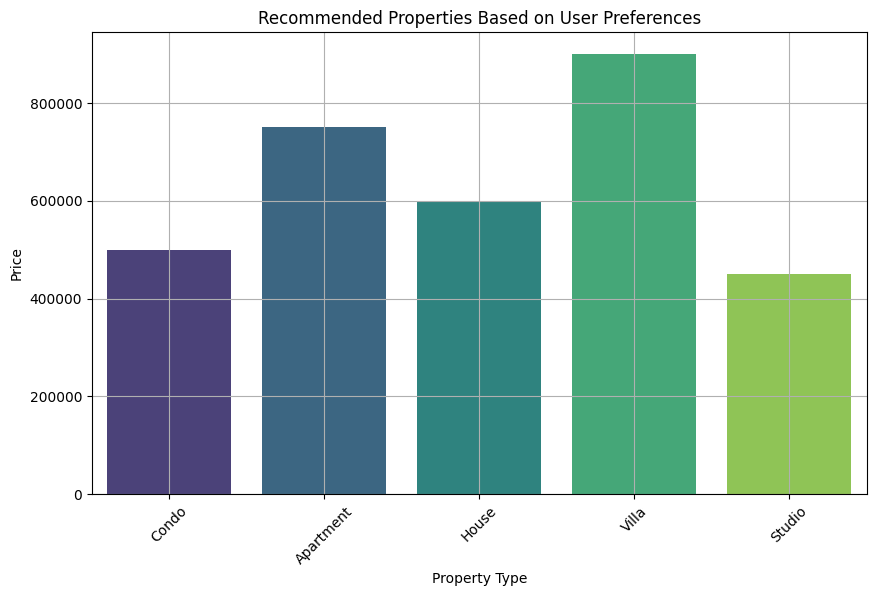

In [ ]:
import pandas as pd

# Example DataFrame to test visualization
test_data = pd.DataFrame({
    'property_type': ['Condo', 'Apartment', 'House', 'Villa', 'Studio'],
    'price': [500000, 750000, 600000, 900000, 450000]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=test_data, x='property_type', y='price', palette='viridis')
plt.title('Recommended Properties Based on User Preferences')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.show()